# Interactions between ProTα and Histone H1.0 evolution variants

In [33]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Data preparation

### Topologies

#### Compact frames

In [4]:
# Loading trajectories
trajs = {}
resultsdir = "results/single_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    trajs[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

In [7]:
# Saving most compact frame as topology
for variant, traj in trajs.items():
    compact_frame = analyse_utils.compact_frame(traj)
    compact_frame.save_pdb(f'data/{variant}.pdb')

#### Merging

In [2]:
# Loading topologies
H10_vars = {}
ProTa = None
data_path = 'data'
for file in os.listdir(data_path):
    if '.pdb' in file:
        traj = md.load(f'{data_path}/{file}')

        id = file[:-4]
        if ('H1-0_VAR' in id) and ('PROTA_WT' not in id):
            H10_vars[id] = traj

        elif 'PROTA_WT' == id:
            ProTa = traj

print(H10_vars.keys())

dict_keys(['H1-0_VAR_k0.21', 'H1-0_VAR_k0.80', 'H1-0_VAR_k0.14', 'H1-0_VAR_k0.36', 'H1-0_VAR_k0.46', 'H1-0_VAR_k0.18', 'H1-0_VAR_k0.30', 'H1-0_VAR_k0.89', 'H1-0_VAR_k0.70', 'H1-0_VAR_k0.92', 'H1-0_VAR_k0.85', 'H1-0_VAR_k0.27', 'H1-0_VAR_k0.75', 'H1-0_VAR_k0.60', 'H1-0_VAR_k0.65', 'H1-0_VAR_k0.55', 'H1-0_VAR_k0.50', 'H1-0_VAR_k0.40', 'H1-0_VAR_k0.07', 'H1-0_VAR_k0.11'])


In [3]:
# Making sets of topologies
twochain_sets = [[H10_var, ProTa] for H10_var in H10_vars.values()]

In [4]:
# Translating topologies
for tc_set  in twochain_sets:
    translate_x = 10 # nm
    translate_y = 0 # nm
    translate_z = 0 # nm
    for i, traj in enumerate(tc_set):
        traj.center_coordinates()
        traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [5]:
# Merging topologies
boxlength = 25 # nm
tc_merges = [simulate_utils.merge_topologies(tc_set, boxlength=boxlength) for tc_set in twochain_sets]
for traj in tc_merges:
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2

In [6]:
# Saving merged topologies
for traj, H10_var_id in zip(tc_merges, H10_vars.keys()):
    filename = f'data/{H10_var_id}_PROTA_WT_{boxlength}nm.pdb'
    traj.save(filename)

## Analysis

### Single chain

In [220]:
# Loading trajectories
traj = {}
resultsdir = "results/single_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    traj[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

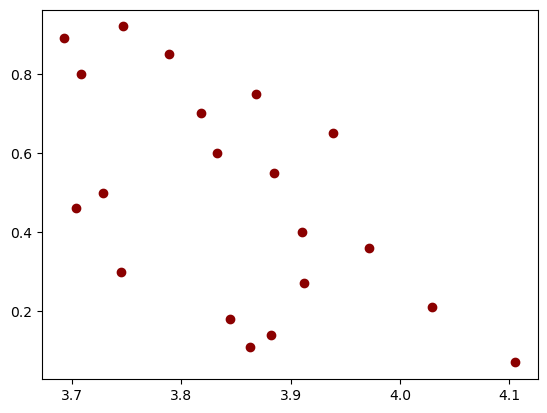

In [221]:
# Checking Rg kappa range
kappas = [float(var[-4:]) for var in traj]
rgs = [analyse_utils.compute_rg(t) for t in traj.values()]
mean_rgs = [rg.mean() for rg in rgs]
data = pd.DataFrame({'kappa': kappas, 'Rg': rgs, '<Rg>': mean_rgs}, index=traj.keys())

plt.scatter(data['<Rg>'], data['kappa'], color='darkred')

In [225]:
data[['kappa', '<Rg>']].sort_values('kappa')

kappa      <Rg>
H1-0_VAR_k0.07   0.07  4.105653
H1-0_VAR_k0.11   0.11  3.862372
H1-0_VAR_k0.14   0.14  3.882315
H1-0_VAR_k0.18   0.18  3.844527
H1-0_VAR_k0.21   0.21  4.029222
H1-0_VAR_k0.27   0.27  3.912604
H1-0_VAR_k0.30   0.30  3.744918
H1-0_VAR_k0.36   0.36  3.971769
H1-0_VAR_k0.40   0.40  3.910393
H1-0_VAR_k0.46   0.46  3.703828
H1-0_VAR_k0.50   0.50  3.728549
H1-0_VAR_k0.55   0.55  3.884606
H1-0_VAR_k0.60   0.60  3.832643
H1-0_VAR_k0.65   0.65  3.938961
H1-0_VAR_k0.70   0.70  3.817959
H1-0_VAR_k0.75   0.75  3.868042
H1-0_VAR_k0.80   0.80  3.708057
H1-0_VAR_k0.85   0.85  3.788185
H1-0_VAR_k0.89   0.89  3.692790
H1-0_VAR_k0.92   0.92  3.746275

### Two chain

In [2]:
# Loading trajectories
traj = {}
residues = {}
resultsdir = "results/two_chain/ionic_240"
for variant in sorted(os.listdir(resultsdir)):
    dir = f"{resultsdir}/{variant}"
    traj[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")
    residues[variant] = simulate_utils.extract_sequences(traj[variant].top)

#### Distances

20it [19:54, 59.70s/it]


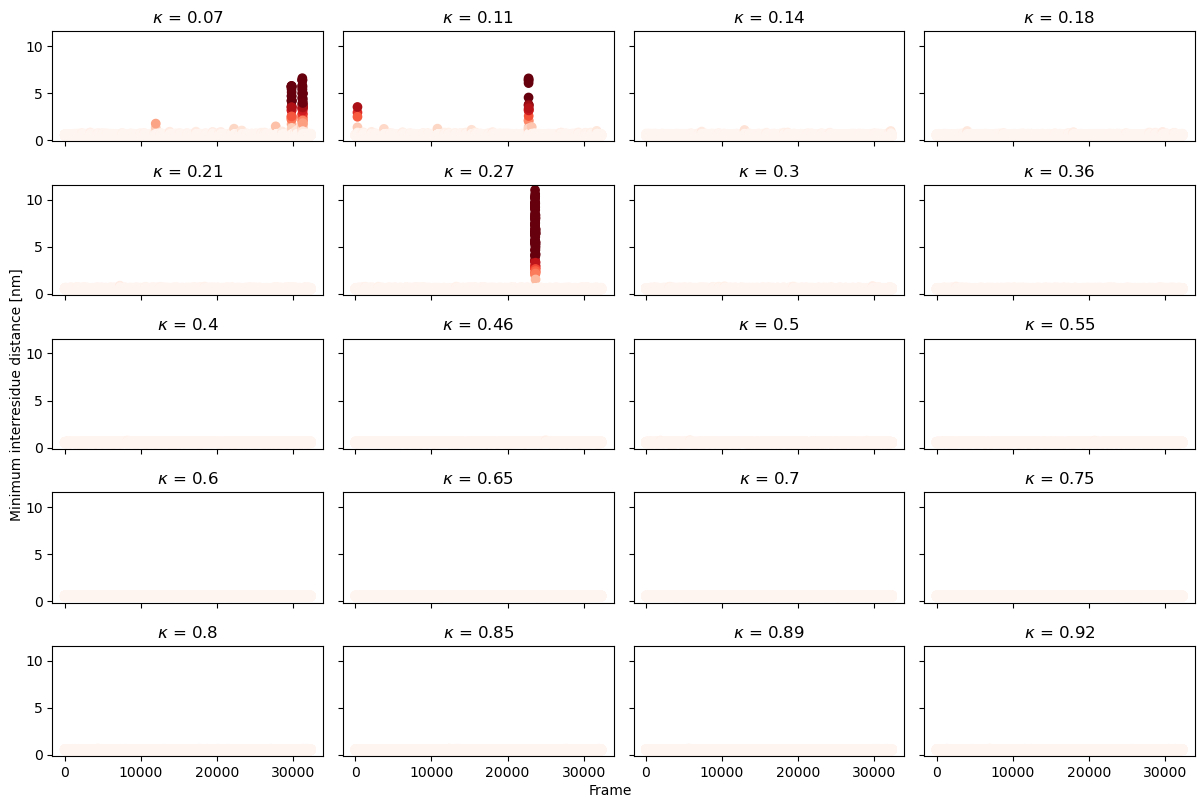

In [219]:
# Finding separation events
from matplotlib import colormaps
from tqdm import tqdm

fig, axes = plt.subplots(5,4,figsize=(12,8), sharex=True, sharey=True)
for i, variant in tqdm(enumerate(sorted(traj))):
    ax = axes.flatten()[i]

    # Finding interchain pairs
    var_traj = traj[variant]
    inter_pairs = var_traj.top.select_pairs('chainid 0', 'chainid 1')

    # Calculating interresidue distances
    dist = md.geometry.squareform(md.compute_distances(var_traj, inter_pairs), inter_pairs)

    # Selecting interresidue distances in distance matrix
    dist_inter = dist[:, np.unique(inter_pairs[:,0]), :][:, :, np.unique(inter_pairs[:,1])]

    # Finding minimum interresidue distance in each frame
    min_dist_inter = dist_inter.min(axis=(1,2))

    # Plotting
    cmap = colormaps['Reds']
    norm = plt.Normalize(0,4)
    ax.scatter(range(len(min_dist_inter)), min_dist_inter, color=cmap(norm(min_dist_inter)))
    kappa = float(variant[10:14])
    ax.set_title(f"$\kappa$ = {kappa}")

fig.text(0.5, 0, 'Frame', ha='center')
fig.text(0, 0.5, 'Minimum interresidue distance [nm]', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

In [233]:
r = simulate_utils.extract_sequences(var_traj.top)

0it [00:00, ?it/s]/tmp/ipykernel_9622/4066413067.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.imshow(mean_dist_inter, vmin=0, vmax=4, cmap=plt.cm.get_cmap('Reds_r'))
20it [00:01, 13.81it/s]


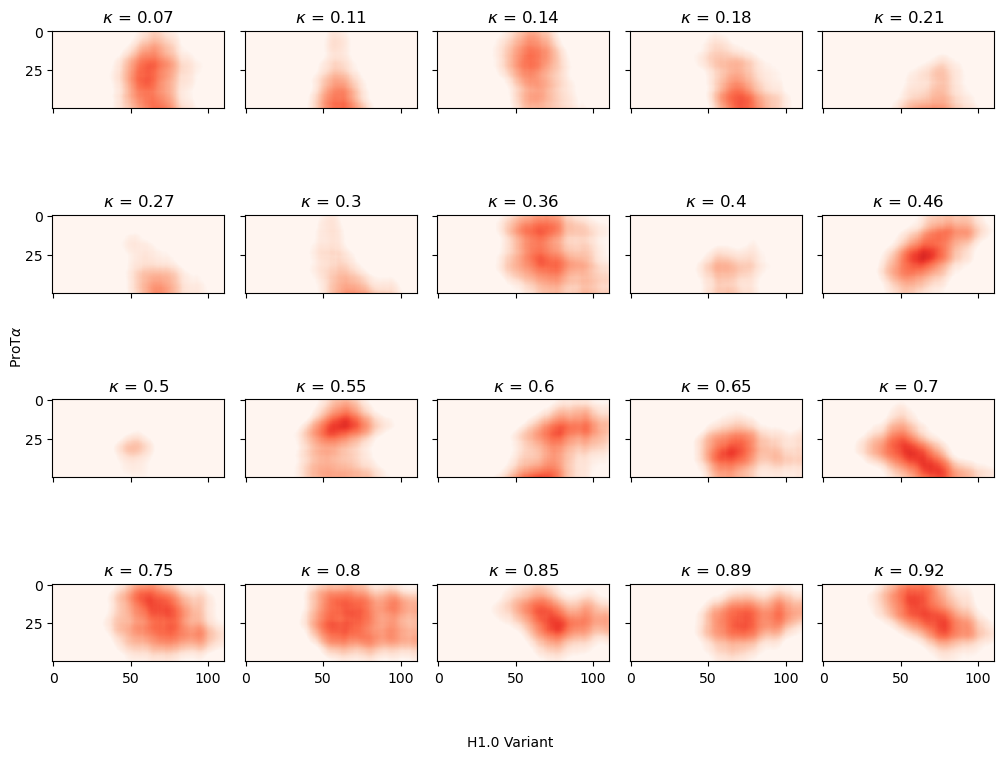

In [236]:
# Finding distances
from tqdm import tqdm

fig, axes = plt.subplots(4,5,figsize=(10,8), sharex=True, sharey=True)
for i, variant in tqdm(enumerate(sorted(traj))):
    ax = axes.flatten()[i]

    # Finding interchain pairs
    var_traj = traj[variant][:100]
    inter_pairs = var_traj.top.select_pairs('chainid 0', 'chainid 1')

    # Calculating interresidue distances
    dist = md.geometry.squareform(md.compute_distances(var_traj, inter_pairs), inter_pairs)

    # Selecting interresidue distances in distance matrix
    dist_inter = dist[:, np.unique(inter_pairs[:,0]), :][:, :, np.unique(inter_pairs[:,1])]

    # Finding mean interresidue distance
    mean_dist_inter = dist_inter.mean(axis=0)

    # Plotting
    ax.imshow(mean_dist_inter, vmin=0, vmax=4, cmap=plt.cm.get_cmap('Reds_r'))
    kappa = float(variant[10:14])
    ax.set_title(f"$\kappa$ = {kappa}")

fig.text(0.5, 0, 'ProT$\\alpha$', ha='center')
fig.text(0, 0.5, 'H1.0 Variant', va='center', rotation='vertical')
#plt.colorbar(label="Distance [nm]")
plt.tight_layout()
plt.show()

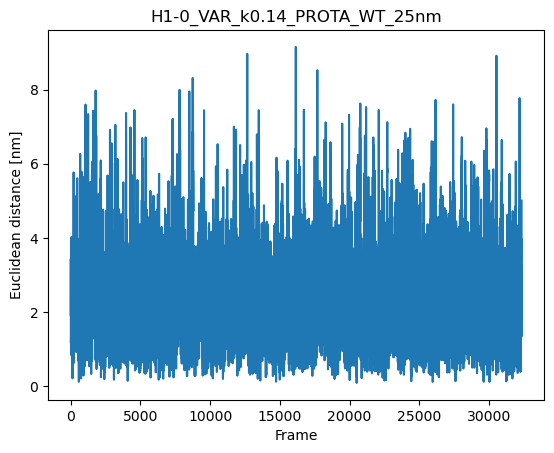

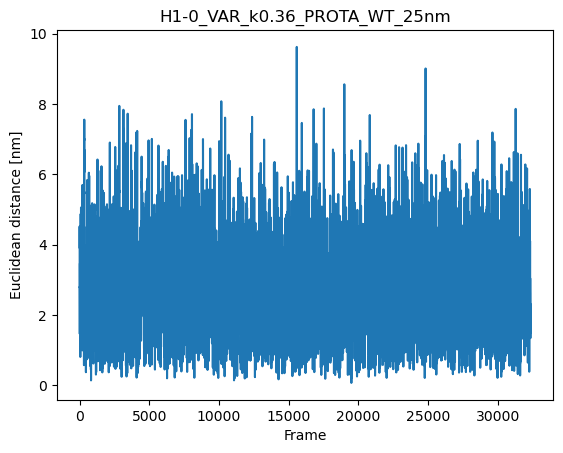

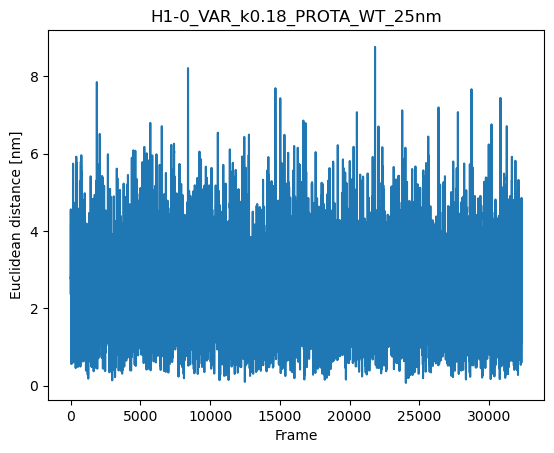

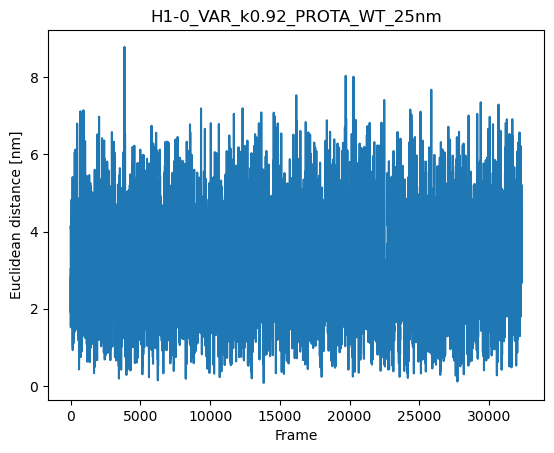

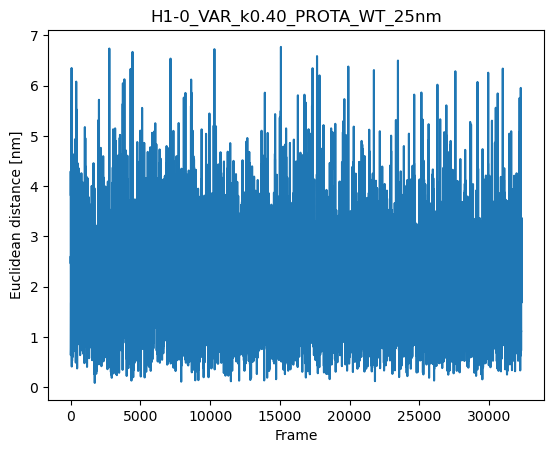

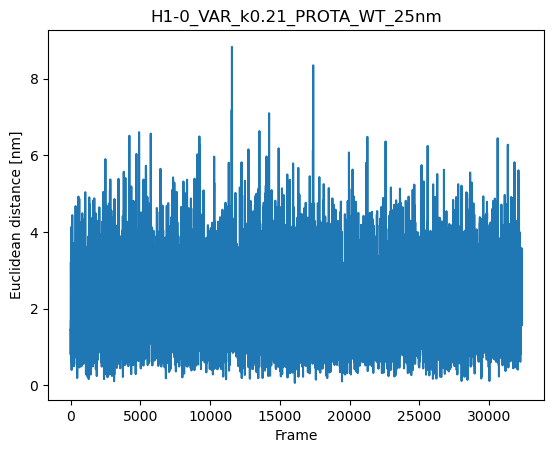

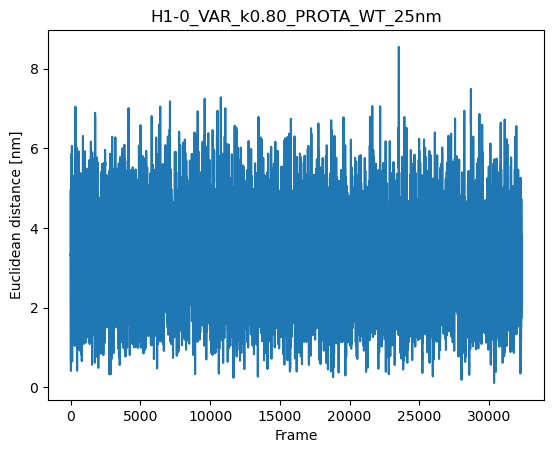

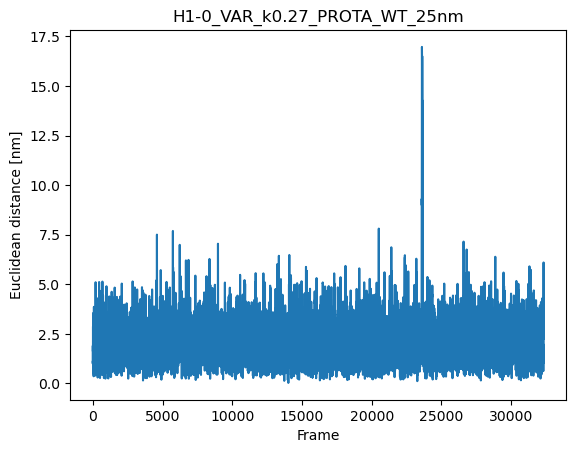

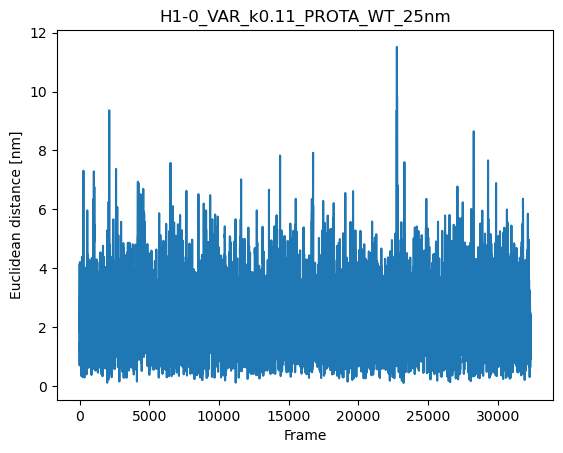

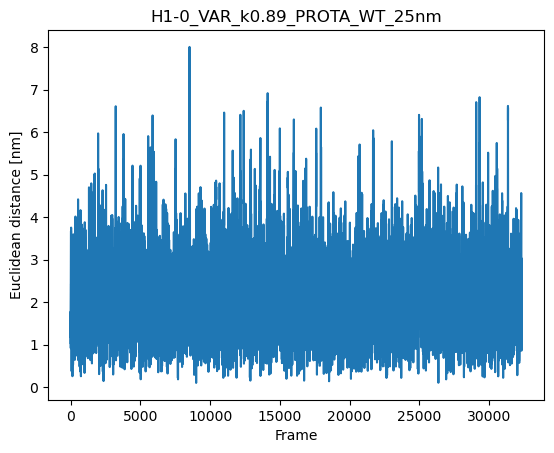

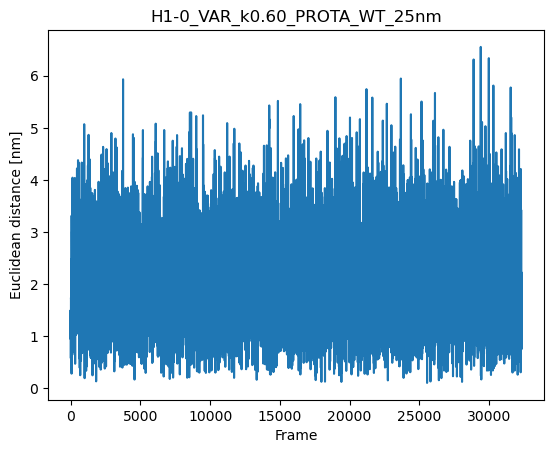

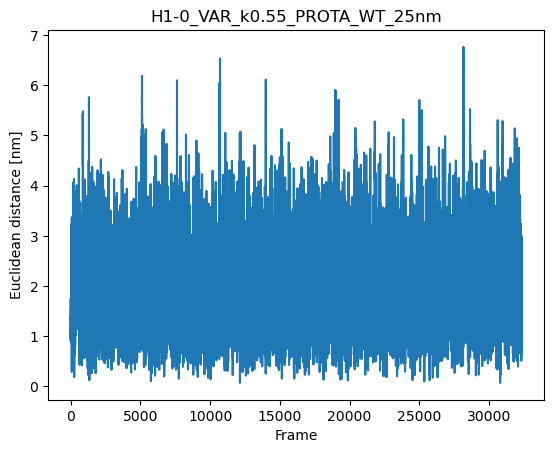

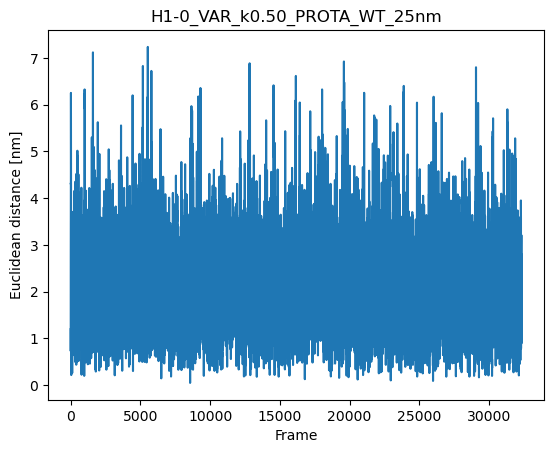

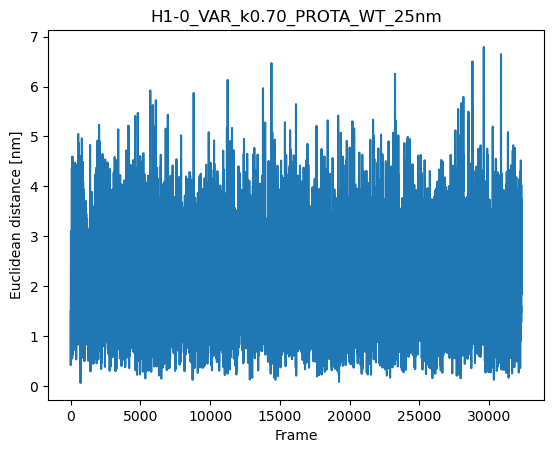

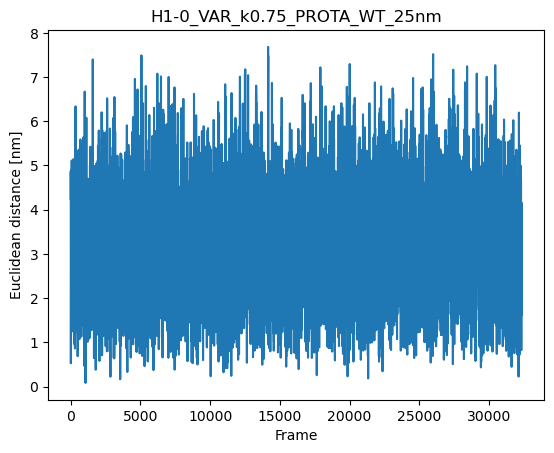

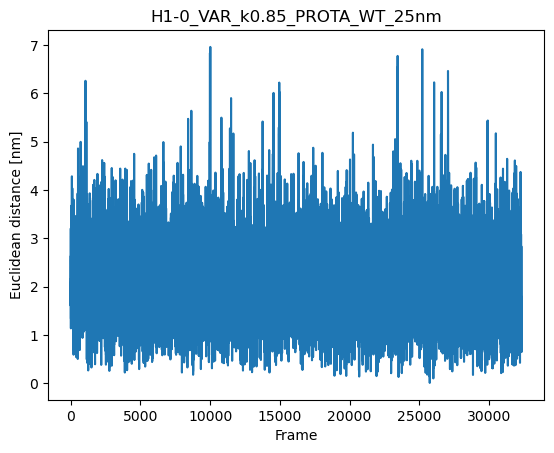

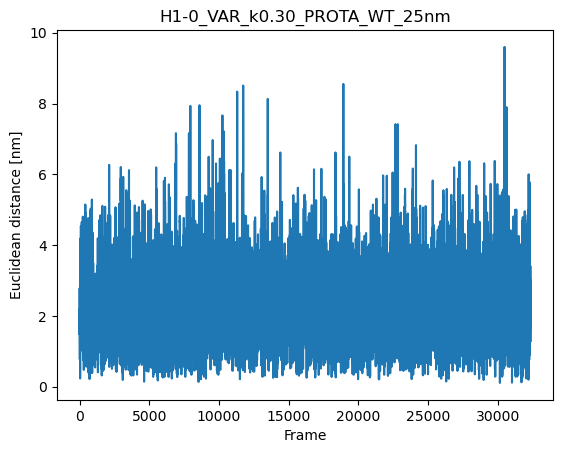

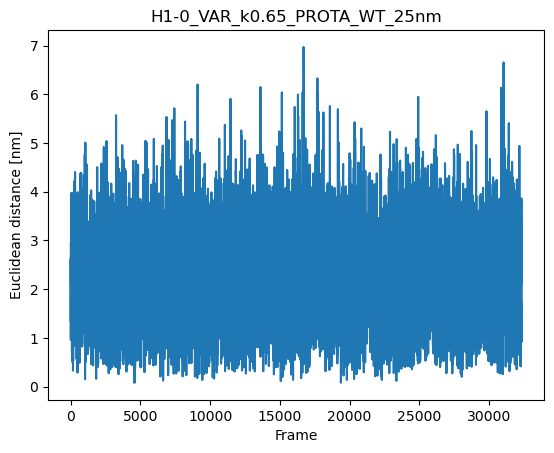

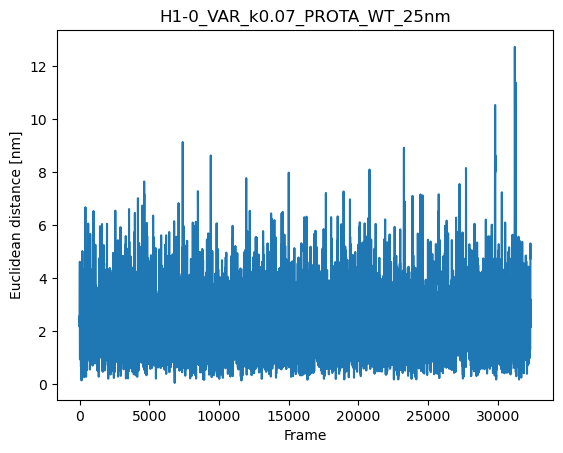

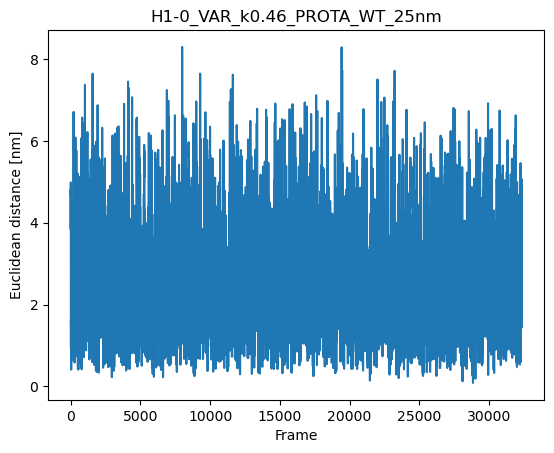

In [9]:
# Computing center of mass c
for variant in traj:
    com_H10 = analyse_utils.compute_com(traj[variant].atom_slice(residues[variant].res[residues[variant].chain == 0]))
    com_ProTa = analyse_utils.compute_com(traj[variant].atom_slice(residues[variant].res[residues[variant].chain == 1]))
    com_diff = (((com_H10-com_ProTa)**2).sum(axis=1))**0.5
    plt.plot(com_diff)
    plt.title(variant)
    plt.xlabel("Frame")
    plt.ylabel("Euclidean distance [nm]")
    plt.show()

#### $K_d$

In [5]:
# Copying from DeiC
resultsdir = "results/two_chain/ionic_240"
for variant in sorted(os.listdir(resultsdir)):
    file = f"{resultsdir}/{variant}/interaction_energy.csv"
    !scp fend01:~/OrthoIDP/exp/prota_variant/$file $file

interaction_energy.csv                        100%   49MB   6.8MB/s   00:07    
interaction_energy.csv                        100% 2280KB   5.4MB/s   00:00    
interaction_energy.csv                        100%   28MB   6.8MB/s   00:04    
interaction_energy.csv                        100%   21MB   6.7MB/s   00:03    
interaction_energy.csv                        100%   49MB   7.0MB/s   00:07    
interaction_energy.csv                        100% 2281KB   6.2MB/s   00:00    
interaction_energy.csv                        100%   49MB   7.0MB/s   00:07    
interaction_energy.csv                        100%   23MB   6.8MB/s   00:03    
interaction_energy.csv                        100%   49MB   6.9MB/s   00:07    
interaction_energy.csv                        100%   49MB   6.6MB/s   00:07    
interaction_energy.csv                        100%  917KB   5.2MB/s   00:00    
interaction_energy.csv                        100%   28MB   6.9MB/s   00:04    
interaction_energy.csv                  

In [7]:
# Loading precomputed energies
datas = {}
resultsdir = "results/two_chain/ionic_240"
for variant in sorted(os.listdir(resultsdir)):
    file = f"{resultsdir}/{variant}/interaction_energy.csv"
    try:
        datas[variant] = pd.read_csv(file)
        datas[variant]['Total energy [kJ/mol]'] = datas[variant]['Ashbaugh-Hatch [kJ/mol]'] + datas[variant]['Debye-Hückel [kJ/mol]']
        data['kappa'] = variant[10:14]
    except:
        continue
print(*datas.keys(), sep='\n')

H1-0_VAR_k0.07_PROTA_WT_25nm
H1-0_VAR_k0.11_PROTA_WT_25nm
H1-0_VAR_k0.14_PROTA_WT_25nm
H1-0_VAR_k0.18_PROTA_WT_25nm
H1-0_VAR_k0.21_PROTA_WT_25nm
H1-0_VAR_k0.27_PROTA_WT_25nm
H1-0_VAR_k0.30_PROTA_WT_25nm
H1-0_VAR_k0.36_PROTA_WT_25nm
H1-0_VAR_k0.40_PROTA_WT_25nm
H1-0_VAR_k0.46_PROTA_WT_25nm
H1-0_VAR_k0.50_PROTA_WT_25nm
H1-0_VAR_k0.55_PROTA_WT_25nm
H1-0_VAR_k0.60_PROTA_WT_25nm
H1-0_VAR_k0.65_PROTA_WT_25nm
H1-0_VAR_k0.70_PROTA_WT_25nm
H1-0_VAR_k0.75_PROTA_WT_25nm
H1-0_VAR_k0.80_PROTA_WT_25nm
H1-0_VAR_k0.85_PROTA_WT_25nm
H1-0_VAR_k0.89_PROTA_WT_25nm
H1-0_VAR_k0.92_PROTA_WT_25nm


In [8]:
data = datas['H1-0_VAR_k0.07_PROTA_WT_25nm']
data

Unnamed: 0  Ashbaugh-Hatch [kJ/mol]  Debye-Hückel [kJ/mol]  \
0                0                -7.450721             -42.391585   
1                1                -4.029157             -20.503683   
2                2                -5.482206              -9.391069   
3                3                -5.837596             -15.958909   
4                4                -7.763127             -26.497869   
...            ...                      ...                    ...   
697995      697995                 2.234923              -5.498338   
697996      697996                 3.185176              -2.199279   
697997      697997                 1.972708              -7.907863   
697998      697998                 8.680341              -9.095940   
697999      697999                -0.506461             -15.929500   

        Minimum interresidue distance [nm]  Center of mass distance [nm]  \
0                                 0.505939                      2.368316   
1                                 0.546288                      2.464307   
2                                 0.510248                      2.571318   
3                                 0.554389                      2.452370   
4                                 0.555293                      2.553748   
...                                    ...                           ...   
697995                            0.586224                      8.214957   
697996                            0.555949                      8.334121   
697997                            0.639506                      7.983822   
697998                            0.545674                      6.831281   
697999                            0.494887                      7.181820   

        Total energy [kJ/mol]  
0                  -49.842306  
1                  -24.532840  
2                  -14.873275  
3                  -21.796504  
4                  -34.260996  
...                       ...  
697995              -3.263415  
697996               0.985897  
697997              -5.935156  
697998              -0.415599  
697999             -16.435961  

[698000 rows x 6 columns]

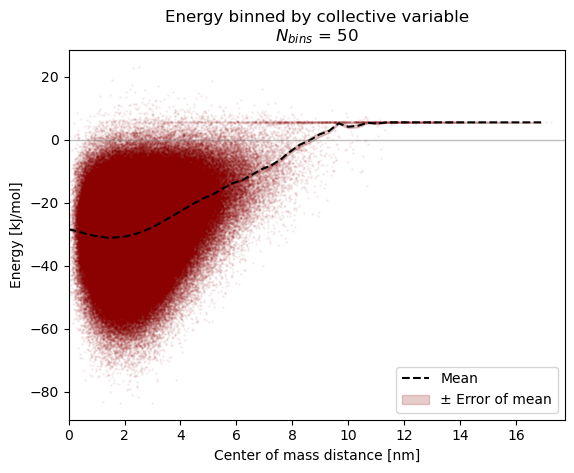

H1-0_VAR_k0.07_PROTA_WT_25nm 5.87607593904448


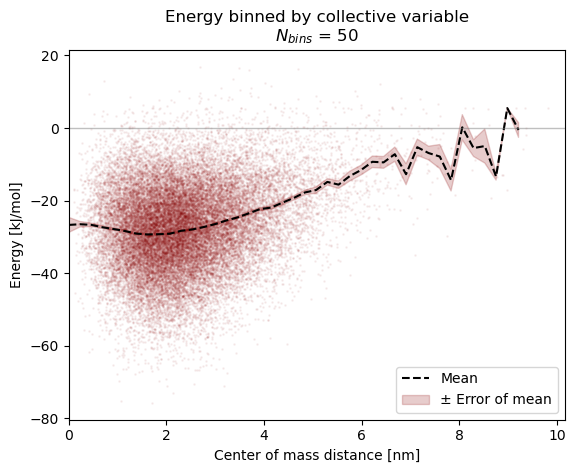

H1-0_VAR_k0.11_PROTA_WT_25nm 11.458613043944416


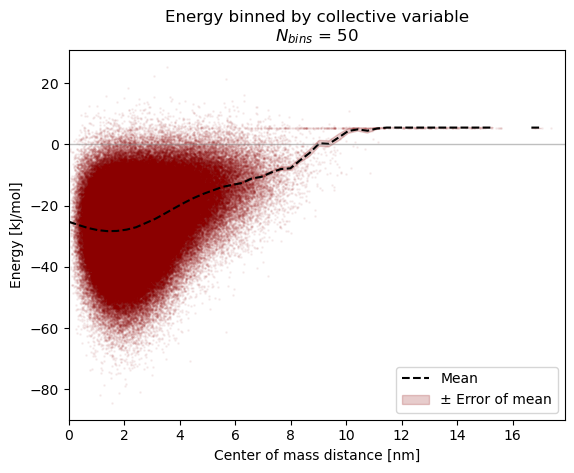

H1-0_VAR_k0.14_PROTA_WT_25nm 18.17202122978214


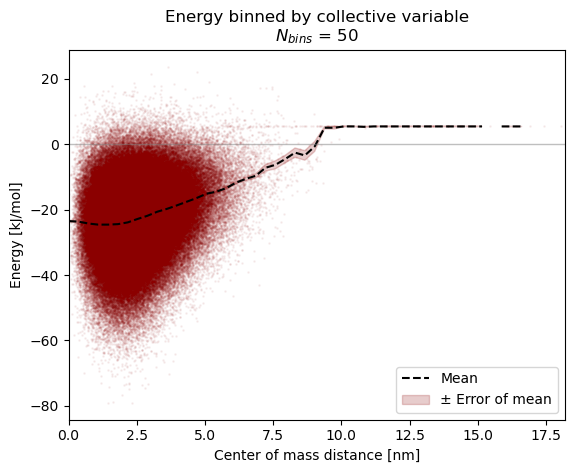

H1-0_VAR_k0.18_PROTA_WT_25nm 65.24979673920049


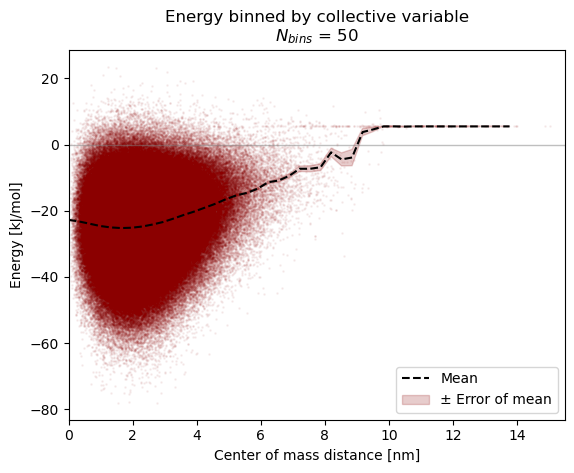

H1-0_VAR_k0.21_PROTA_WT_25nm 41.53803219389585


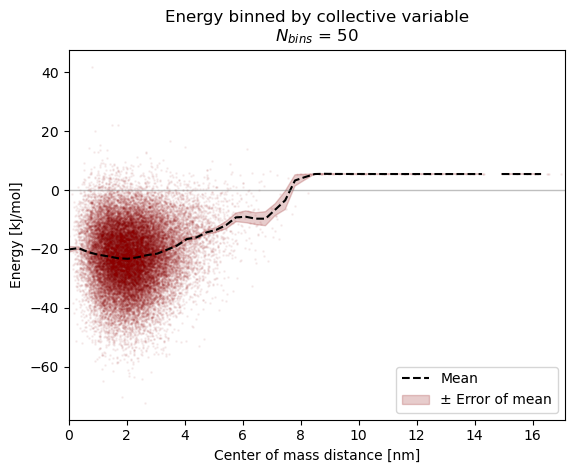

H1-0_VAR_k0.27_PROTA_WT_25nm 90.57563133759373


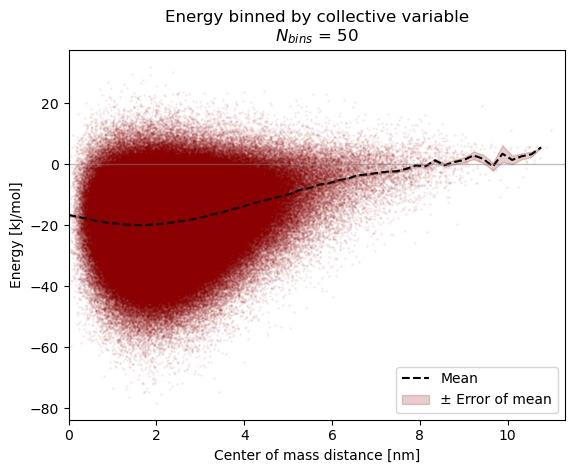

H1-0_VAR_k0.30_PROTA_WT_25nm 427.8191909902334


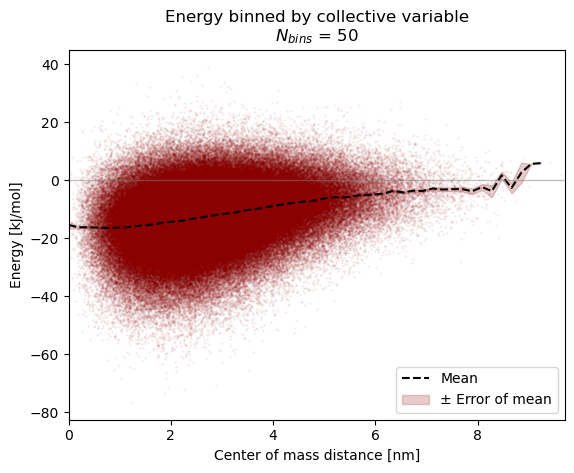

H1-0_VAR_k0.36_PROTA_WT_25nm 2326.934474353991


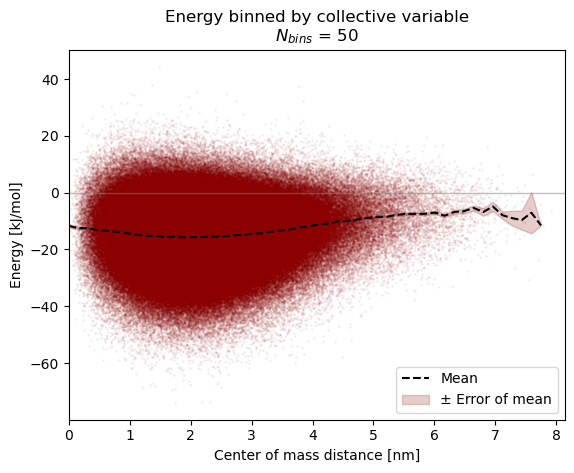

H1-0_VAR_k0.40_PROTA_WT_25nm 82866.22465998684


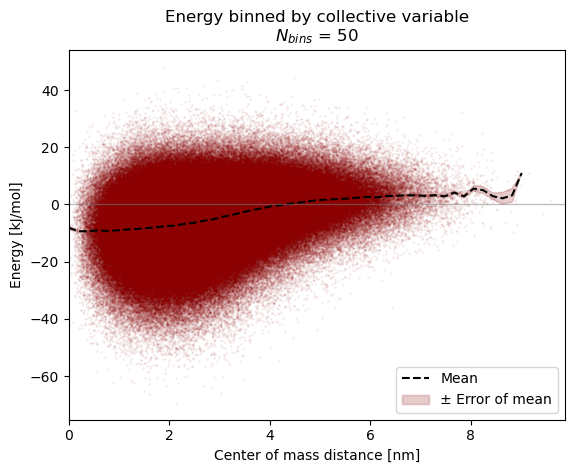

H1-0_VAR_k0.46_PROTA_WT_25nm 4546.998511827664


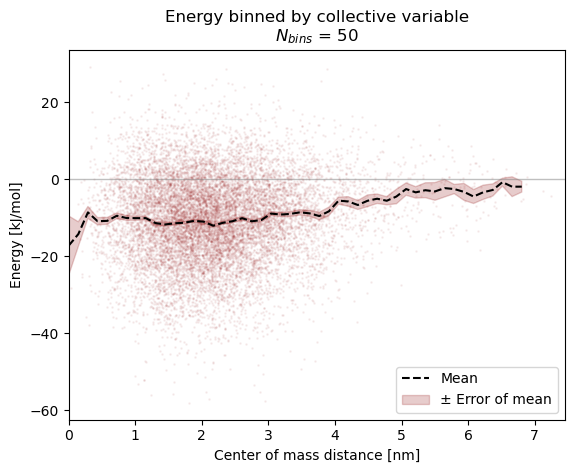

H1-0_VAR_k0.50_PROTA_WT_25nm 105087.70517351628


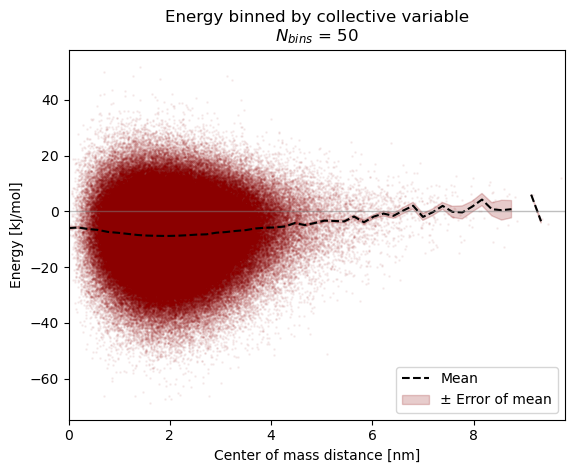

H1-0_VAR_k0.55_PROTA_WT_25nm 12798.444740368861


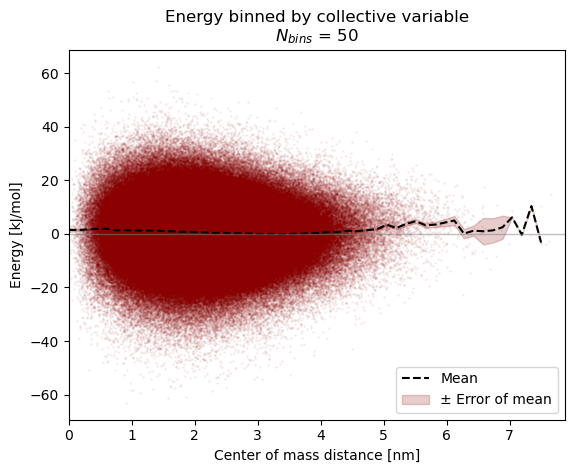

H1-0_VAR_k0.60_PROTA_WT_25nm 23019.423234069884


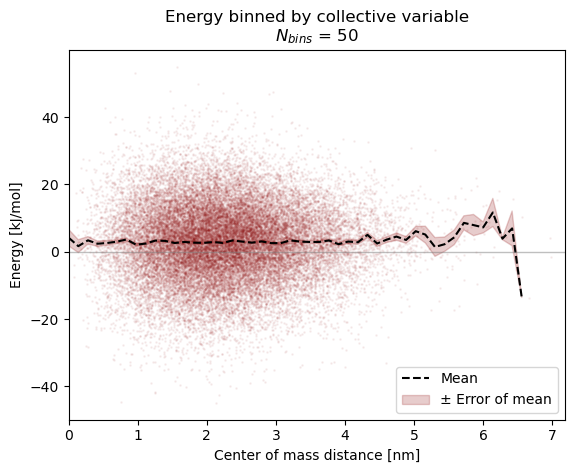

H1-0_VAR_k0.65_PROTA_WT_25nm 350.9255034921413


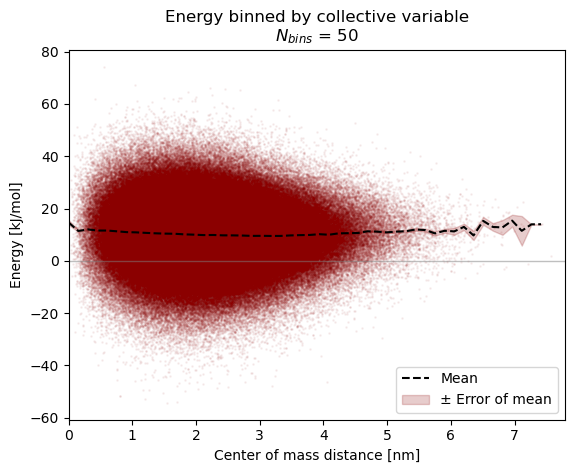

H1-0_VAR_k0.70_PROTA_WT_25nm 181913.71769512363


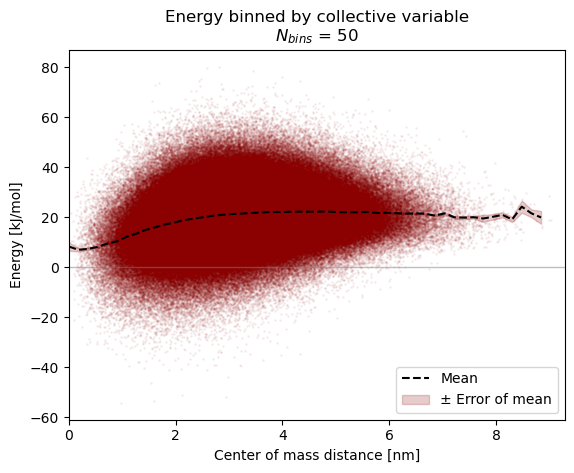

H1-0_VAR_k0.75_PROTA_WT_25nm 109649.39757047001


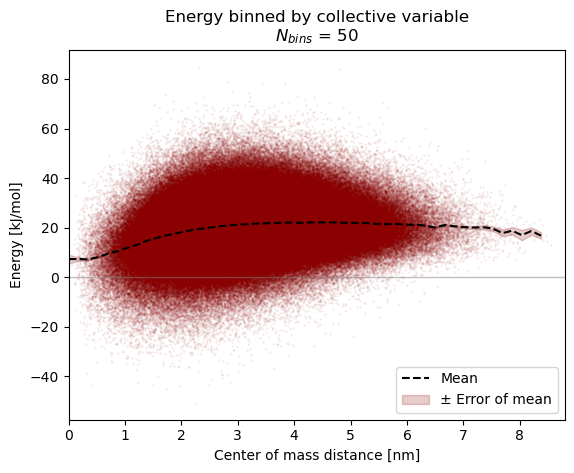

H1-0_VAR_k0.80_PROTA_WT_25nm 202883.51297812714


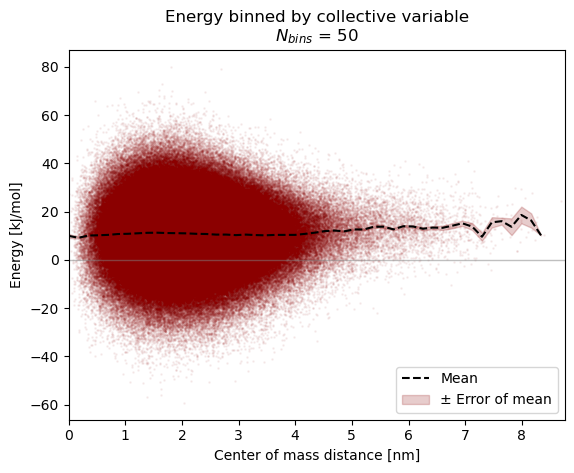

H1-0_VAR_k0.85_PROTA_WT_25nm 59242.97771496397


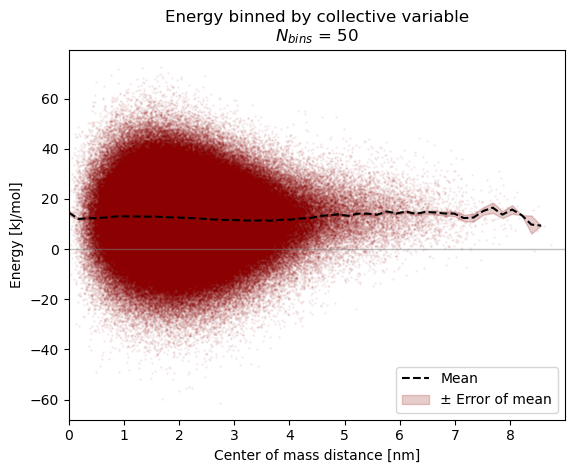

H1-0_VAR_k0.89_PROTA_WT_25nm 138678.1376503633


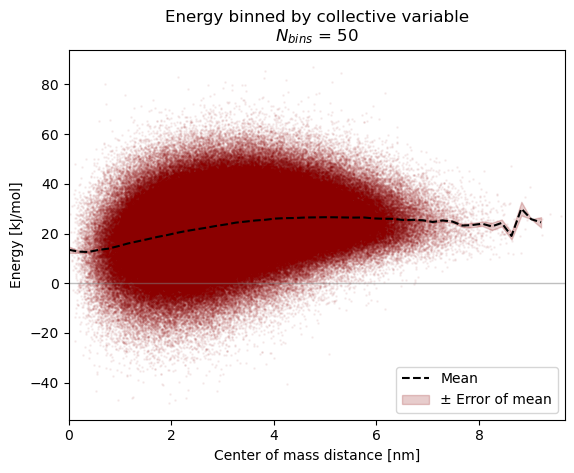

H1-0_VAR_k0.92_PROTA_WT_25nm 29922.84588681633


In [13]:
Kds = {}
for key, data in datas.items():
    Kd = analyse_utils.compute_Kd(data['Total energy [kJ/mol]'], data['Center of mass distance [nm]'], 298, 50)
    print(key, Kd)
    Kds[key] = key[10:14]
    plt.show()
Kds = pd.Series(Kds)

In [17]:
print(len('H1-0_VAR_k'))

10


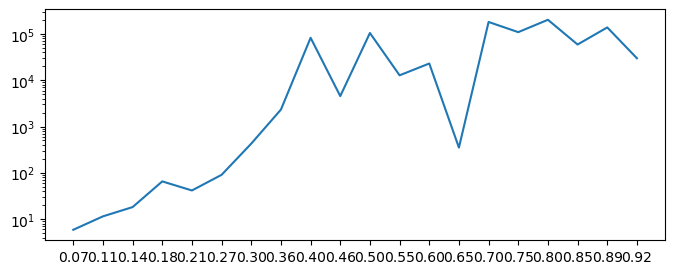

In [32]:
plt.figure(figsize=(8,3))
plt.plot(Kds)
plt.yscale('log')

In [41]:
all = pd.concat(datas.values(), axis=0).iloc[:,1:]

In [42]:
all

Ashbaugh-Hatch [kJ/mol]  Debye-Hückel [kJ/mol]  \
0                     -7.450721             -42.391585   
1                     -4.029157             -20.503683   
2                     -5.482206              -9.391069   
3                     -5.837596             -15.958909   
4                     -7.763127             -26.497869   
...                         ...                    ...   
696995                -5.607831              25.372562   
696996                -4.946965              17.383196   
696997                -1.884863              44.661915   
696998                -1.751550              23.964303   
696999                 5.063333              31.072240   

        Minimum interresidue distance [nm]  Center of mass distance [nm]  \
0                                 0.505939                      2.368316   
1                                 0.546288                      2.464307   
2                                 0.510248                      2.571318   
3                                 0.554389                      2.452370   
4                                 0.555293                      2.553748   
...                                    ...                           ...   
696995                            0.542709                      5.979350   
696996                            0.564351                      5.200157   
696997                            0.566699                      4.293477   
696998                            0.567393                      3.906862   
696999                            0.548755                      3.384350   

        Total energy [kJ/mol] kappa  
0                  -49.842306  0.07  
1                  -24.532840  0.07  
2                  -14.873275  0.07  
3                  -21.796504  0.07  
4                  -34.260996  0.07  
...                       ...   ...  
696995              19.764731  0.92  
696996              12.436231  0.92  
696997              42.777053  0.92  
696998              22.212753  0.92  
696999              36.135573  0.92  

[9899000 rows x 6 columns]

In [74]:
all['Contact'] = all['Minimum interresidue distance [nm]'] < 4
(~all.Contact).groupby(all.kappa).sum() / ((all.Contact).groupby(all.kappa).sum())**2

kappa
0.07    1.701470e-09
0.11    4.884339e-09
0.14    1.640192e-09
0.18    1.568140e-09
0.21    3.860833e-10
0.27    6.767434e-08
0.30    4.515847e-11
0.36    0.000000e+00
0.40    0.000000e+00
0.46    0.000000e+00
0.50    0.000000e+00
0.55    0.000000e+00
0.60    0.000000e+00
0.65    0.000000e+00
0.70    0.000000e+00
0.75    0.000000e+00
0.80    0.000000e+00
0.85    0.000000e+00
0.89    0.000000e+00
0.92    0.000000e+00
Name: Contact, dtype: float64